# HW 4 
Корешков

## Завдання 7
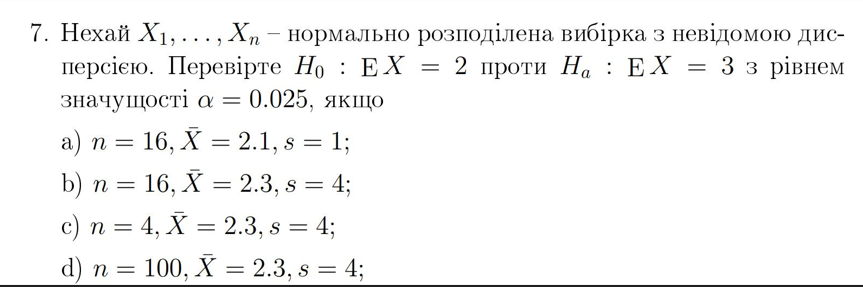


**Формулювання 1**

$X_1, ..., X_n \sim \mathcal N (\mu, \sigma^2)$, iid  
$\mu,\sigma^2$ - невідомі

Нульова гіпотеза $H_0 : EX = 2$.  
Альтернативна гіпотеза $H_a : EX = 3$.

Рівень значущості $\alpha = 0.025$.

**Формулювання 2**

$X_1, ..., X_n \sim \mathcal N (\mu, \sigma^2)$, iid  
$\mu,\sigma^2$ - невідомі

Нульова гіпотеза $H_0 : EX = 2$.  
Альтернативна гіпотеза $H_a : EX > 2$.

Рівень значущості $\alpha = 0.025$.

В моєму розуміння, обидва випадки матимуть однакові статистичні критерії. В першому формулюванні я сподівався застосувати лему Неймана-Пірсона. Але, насправді,в обох у нас тут складні нульові та альтернативні гіпотези, бо навіть за фіксованого матсподівання, маємо багато можливих дисперсій.

Розглядатимемо задачу у **формулюванні 2**, звідки маємо "модель 2".

Використовується те, що статистика $t(X) = \sqrt{n} \frac{(\overline X_n - \mu_0)}{s_n} \sim t_{n-1}$ розподілена за t-розподілом Стьюдента із $n-1$ ступенями вільності. Далі достатньо порахувати довірчий інтервал, що відповідає лівій, правій, чи двосторонній альтернативній гіпотезі.
- $t(X) = \sqrt{n} \frac{(\overline X_n - \mu_0)}{s_n} = \sqrt{n} \frac{(\overline X_n - 2)}{s_n}$
- Відхиляємо $H_0$ при $t > t_\alpha$
- де $t_\alpha = F^{-1}_{t_{n-1}}(1-\alpha)$

In [3]:
import numpy as np
import scipy as sp
import scipy.stats
from collections import namedtuple

alpha = significance = 0.025
verbose = True

In [84]:
cannot_deny_h0 = "Не можемо відхилити нульову гіпотезу із заданим рівнем значущості."
deny_h0 = "Відхиляємо нульову гіпотезу, приймаючи альтернативну. "

In [85]:
def vprint(*args, indent=0, **kwargs):
    if verbose: 
        print('> '*indent, end='')
        print(*args, **kwargs) 

Реалізую статистичний критерій у пітоні
- Підготувати критерій, порахувати критичну область, тобто $t_\alpha$ за допомогою функції квантиля, вона ж обернена функція розподілу, вона ж PPF, `scipy.stats.t.ppf`  
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.ppf.html#scipy.stats.rv_continuous.ppf
- Порахувати статистику $t(X)$. Якщо $t(X) > t_\alpha$, то відхилити нульову гіпотезу
- Також порівняю результат із аналогічним вбудованим у scipy статистичним критерієм. В даному випадку порівнюю із функцією `ttest_1samp` із `alternative='greater'`   
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_1samp.html#scipy.stats.ttest_1samp

Зауваження: функції статистичних тестів Scipy приймають лише вибірки, а не тільки пораховані вибіркові середнє та дисперсію. Тому для перевірки, чи узгоджуються мої результати із результатами scipy, я написав функцію, що генерує майже нормальний випадковий вектор із **точними** значеннями вибіркового середнього та вибіркової дисперсії

In [89]:
# Generate almost normal random samples with strictly defined mean and variance
def generate_normal_rvs(n, mean, var):
    assert n>1
    
    # generate random variates
    init_rvs = sp.stats.norm.rvs(loc=0, scale=var, size=n)

    # adjust sample to zero mean
    zero_mean_rvs = init_rvs - init_rvs.mean()
    zero_mean_var_nom = np.square(zero_mean_rvs).sum()
    needed_var_nom = var*n
    # adjust sample to defined variance
    zero_mean_ok_var_rvs = zero_mean_rvs * np.sqrt(needed_var_nom / zero_mean_var_nom)
    # print(zero_mean_ok_var_rvs.mean(), zero_mean_ok_var_rvs.var())

    # adjust sample to defined mean
    rvs = zero_mean_ok_var_rvs + mean

    # verify
    assert np.abs(rvs.var() - var) < 1e-8, f"{rvs.mean()}; {rvs.var()}"
    assert np.abs(rvs.mean() - mean) < 1e-8, f"{rvs.mean()}; {rvs.var()}"

    return rvs

a = generate_normal_rvs(4, 2.1, 1)
a

array([3.29888506, 0.84178579, 1.43044657, 2.82888258])

In [128]:
def test_normal_t_greater(mu0, sample_n, sample_mean, sample_var, significance=significance):
    h0 = f"EX = {mu0:.3g}"
    h1 = f"EX > {mu0:.3g}"
    vprint(f"Перевіряємо статистичну гіпотезу із рівнем значущості {significance:.3g}\n  H0 : {h0}  проти  H1 : {h1}")
    vprint(f"  {sample_n = }; {sample_mean = :.3g}; {sample_var = :.3g};")

    # обернена функція розподілу.
    # беремо (1-alpha), бо alpha це площа під усім правим хвостом розподілу.
    # df = degrees-of-freedom = кількість степенів свободи = n-1
    t_right_crit_val = scipy.stats.t.ppf(1 - significance, df= sample_n-1)
    t = np.sqrt((sample_n-1) / sample_var) * (sample_mean - mu0)
    # спочатку забув тут взяти корінь з дисперсії і нічого не працювало 🙄

    vprint(f"  {t=:.3g}  {'>' if t > t_right_crit_val else '<'}  t_crit={t_right_crit_val:.3g}")

    shall_deny_h0 = t > t_right_crit_val
    if shall_deny_h0: 
        print("  "+deny_h0)
    else:
        print("  "+cannot_deny_h0)

    #
    # Перевірка та порівняння результатів із Scipy

    fake_data = generate_normal_rvs(sample_n, sample_mean, sample_var)
    sp_result = scipy.stats.ttest_1samp(fake_data, popmean=mu0, alternative='greater')
    err_statistic_calculation = np.abs(sp_result.statistic - t) > 1e-6
    err_pvalue_too_large = sp_result.pvalue > significance + 1e-4 
    print()
    print("  Результат ttest_1samp: ")
    print(f"  > t_sp= {sp_result.statistic:.3g} {'!!!' if err_statistic_calculation else ''}")
    print(f"  > pvalue= {sp_result.pvalue:.3g} {'!!!' if err_pvalue_too_large else ''}")
    print(f"  > conf_interv= {sp_result.confidence_interval(1-significance)}")
    
    if err_statistic_calculation:
        print("  Значення статистики не узгоджується із scipy !!!?")

    if err_pvalue_too_large == ~shall_deny_h0:
        print("  Результат узгоджується із scipy 🥳")
    else:
        print("  Результат НЕ УЗГОДЖУЄТСЬЯ ІЗ SCIPY 🛑")
    

In [129]:
print("7.a)")
test_normal_t_greater(2, 16, 2.1, 1)
print()

print("7.b)")
test_normal_t_greater(2, 16, 2.3, 4)
print()

print("7.c)")
test_normal_t_greater(2, 4, 2.3, 4)
print()

print("7.d)")
test_normal_t_greater(2, 100, 2.3, 4)
print()

7.a)
Перевіряємо статистичну гіпотезу із рівнем значущості 0.05
  H0 : EX = 2  проти  H1 : EX > 2
  sample_n = 16; sample_mean = 2.1; sample_var = 1;
  t=0.387  <  t_crit=1.75
  Не можемо відхилити нульову гіпотезу із заданим рівнем значущості.

  Результат ttest_1samp: 
  > t_sp= 0.387 
  > pvalue= 0.352 !!!
  > conf_interv= ConfidenceInterval(low=1.6473643444893167, high=inf)
  Результат узгоджується із scipy 🥳

7.b)
Перевіряємо статистичну гіпотезу із рівнем значущості 0.05
  H0 : EX = 2  проти  H1 : EX > 2
  sample_n = 16; sample_mean = 2.3; sample_var = 4;
  t=0.581  <  t_crit=1.75
  Не можемо відхилити нульову гіпотезу із заданим рівнем значущості.

  Результат ttest_1samp: 
  > t_sp= 0.581 
  > pvalue= 0.285 !!!
  > conf_interv= ConfidenceInterval(low=1.3947286889786334, high=inf)
  Результат узгоджується із scipy 🥳

7.c)
Перевіряємо статистичну гіпотезу із рівнем значущості 0.05
  H0 : EX = 2  проти  H1 : EX > 2
  sample_n = 4; sample_mean = 2.3; sample_var = 4;
  t=0.26  <  t_

## Завдання 8

$X_1, ..., X_n \sim \mathcal N (\mu, \sigma^2)$, iid  
$\mu,\sigma^2$ - невідомі

Нульова гіпотеза $H_0 : DX = 2$.  
Альтернативна гіпотеза $H_a : DX > 2$.

Рівень значущості $\alpha = 0.05$.


"Модель 6"
- $\chi^2(X) = ns_n^2 / \sigma^2_0 = ns_n^2 / 2$
- Відхиляємо нульову гіпотезу якщо $\chi^2(X) > c_2(\alpha)$
- $c_2(\alpha) = F^{-1}_{\chi^2_{n-1}}(1-\alpha)$

В Scipy немає цього тесту, тому я порівнював із функцією `vartest` у матлабі, https://www.mathworks.com/help/stats/vartest.html

In [120]:
alpha = significance = 0.05

In [121]:
def test_normal_chi2_greater(sigma2_0, sample_n, sample_mean, sample_var, significance=significance):
    h0 = f"DX = {sigma2_0:.3g}"
    h1 = f"DX > {sigma2_0:.3g}"
    vprint(f"Перевіряємо статистичну гіпотезу із рівнем значущості {significance:.3g}\n  H0 : {h0}  проти  H1 : {h1}")
    vprint(f"  {sample_n = }; {sample_mean = :.3g}; {sample_var = :.3g};")

    # обернена функція розподілу.
    # беремо (1-alpha), бо alpha це площа під усім правим хвостом розподілу.
    # df = degrees-of-freedom = кількість степенів свободи = n-1
    c_right_crit_val = scipy.stats.chi2.ppf(1 - significance, df= sample_n-1)
    c = (sample_n-1) * sample_var / sigma2_0

    vprint(f"  {c=:.3g}  {'>' if c > c_right_crit_val else '<'}  c_crit={c_right_crit_val:.3g}")

    deny_h0 = c > c_right_crit_val
    if deny_h0: 
        print("  "+deny_h0)
    else:
        print("  "+cannot_deny_h0)


In [122]:
np.set_printoptions(linewidth=np.inf)
a = generate_normal_rvs(16, 2.1, 2.1)
print("a=", a)
b = generate_normal_rvs(16, 2.3, 1.9)
print("b=", b)
c = generate_normal_rvs(4, 2.3, 2.1)
print("c=", c)
d = generate_normal_rvs(100, 2.3, 2.1)
print("d=", d)

a= [ 1.1705056   3.85382531  2.51975317  3.94438857  5.06821841  1.67994524  3.00921772  1.87572113 -0.21102158  0.5304164   2.55674126  2.58475793  0.63247662 -0.05232937  1.45839834  2.97898525]
b= [-0.12421735  2.00282009  0.25256814  1.68821827  5.44309465  2.77004499  1.25692086  0.99062173  2.8013225   1.95128609  4.13436811  1.47028761  2.69684946  3.36456885  2.80343112  3.29781489]
c= [ 3.02451243  3.00552653 -0.19754695  3.36750798]
d= [ 2.81559889  4.00079204  2.49217371  5.22279981  1.26772772  2.0546348   3.88194211  2.57921446  2.97970131  2.13330088  3.14575787  1.64349635 -1.34035279  1.87709647  2.07058386  2.37104721  3.51405778  0.93673274  2.14158586  3.19987556  1.26286257  4.79094721  2.49121188  0.38143815  2.77041397  3.26778311  2.6958111   3.7339621   2.74675886  4.42674947  0.21582628 -0.22168579  1.01558202  1.23927211  2.61644217  2.13379216 -0.46739242  1.98821072  2.49542751  2.20529094  5.20768144  3.86124105  3.73033197  3.28803618  1.50928661  1.730448

In [123]:
test_normal_chi2_greater(2, 16, 2.1, 2.1)
print()
test_normal_chi2_greater(2, 16, 2.3, 1.9)
print()
test_normal_chi2_greater(2, 4, 2.3, 2.1)
print()
test_normal_chi2_greater(2, 100, 2.3, 2.1)

Перевіряємо статистичну гіпотезу із рівнем значущості 0.05
  H0 : DX = 2  проти  H1 : DX > 2
  sample_n = 16; sample_mean = 2.1; sample_var = 2.1;
  c=15.8  <  c_crit=25
  Не можемо відхилити нульову гіпотезу із заданим рівнем значущості.

Перевіряємо статистичну гіпотезу із рівнем значущості 0.05
  H0 : DX = 2  проти  H1 : DX > 2
  sample_n = 16; sample_mean = 2.3; sample_var = 1.9;
  c=14.2  <  c_crit=25
  Не можемо відхилити нульову гіпотезу із заданим рівнем значущості.

Перевіряємо статистичну гіпотезу із рівнем значущості 0.05
  H0 : DX = 2  проти  H1 : DX > 2
  sample_n = 4; sample_mean = 2.3; sample_var = 2.1;
  c=3.15  <  c_crit=7.81
  Не можемо відхилити нульову гіпотезу із заданим рівнем значущості.

Перевіряємо статистичну гіпотезу із рівнем значущості 0.05
  H0 : DX = 2  проти  H1 : DX > 2
  sample_n = 100; sample_mean = 2.3; sample_var = 2.1;
  c=104  <  c_crit=123
  Не можемо відхилити нульову гіпотезу із заданим рівнем значущості.


1. 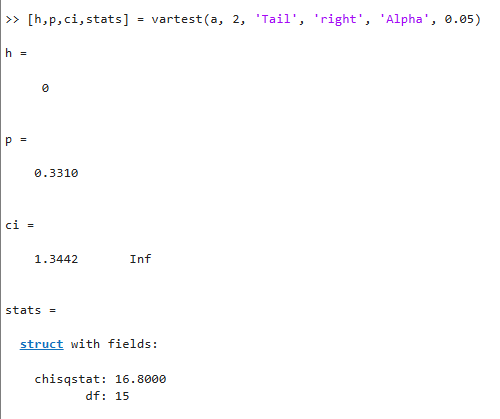
2. 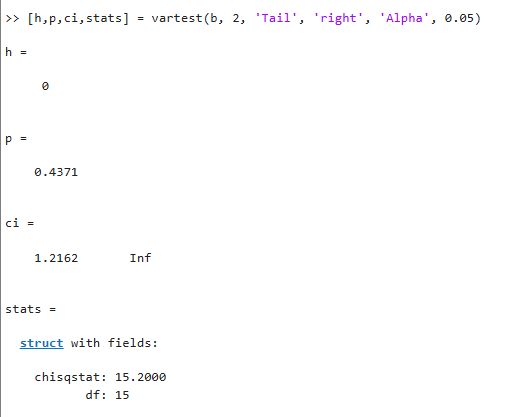
3. 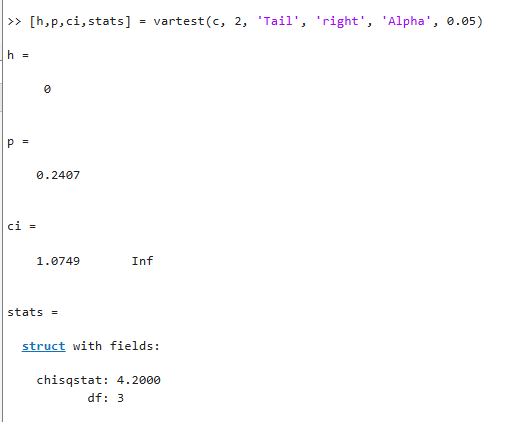
4. 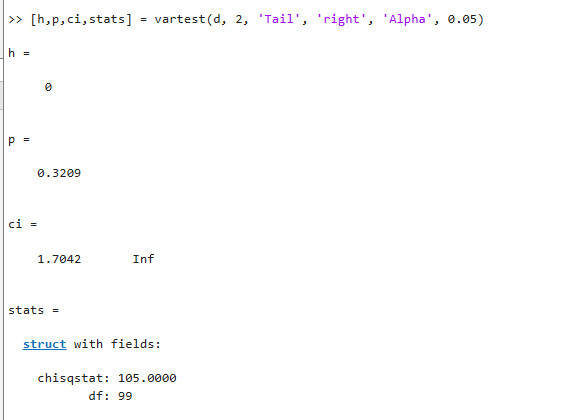

Бачимо, що результати ті самі, але тестова статистика трошки інша. Не знайшов у чому причина.

## Завдання 13

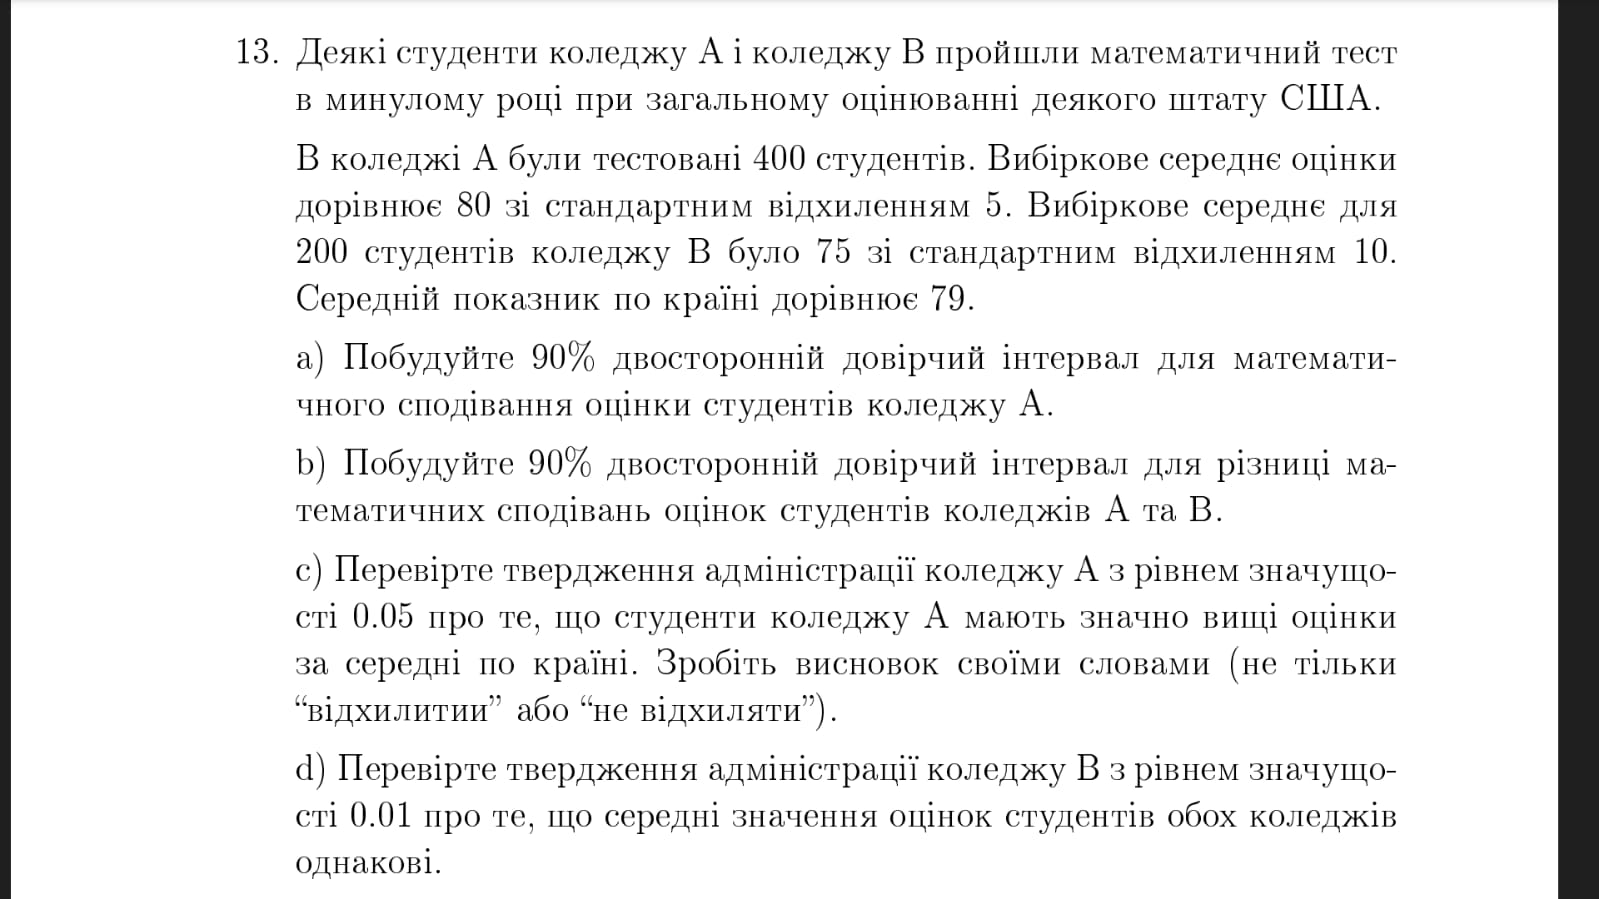

Something something вважаємо що вибірка розподілена нормально за ЦГТ

$A : X_1, ..., X_{n_A} \sim \mathcal N (\mu_A, \sigma^2_A)$  
$B : Y_1, ..., Y_{n_B} \sim \mathcal N (\mu_B, \sigma^2_B)$

In [111]:
n_a = 400
mean_a = 80
var_a = 5

n_b = 200
mean_b = 75
var_b = 10

mean_prior = 79

### 13a

Шукаємо довірчий інтервал $(a;b)$ такий, що $P(a < \mu_A < b) = 0.9$

Зверну увагу, що дисперсія, в принципі, не відома.

Визначимо оцінки  
$\hat \mu_A = \overline X$ та  
$s_A = \frac{\sum_{k=1}^{n_A} (X_k - \overline X)}{n-1}$. 
<!-- 
Лема Фішера про вибіркове середнє та дисперсію нормальної вибірки:  

$\displaystyle U = \sqrt{n_A} \frac{\hat \mu_A - \mu_A}{\sigma_A} \sim \mathcal N(0,1)$

$\displaystyle V = (n_A-1) \frac{s^2_A}{\sigma^2_A} \sim \mathcal \chi^2_{n-1}$  

$U, V$ - незалежні -->

Теорема про статистику Стьюдента від нормальної вибірки:
$$T = \sqrt{n}\frac{\hat \mu_A - \mu_A}{\hat s} \sim t_{n-1}$$
де $t_{n-1}$ - розподіл Стьюдента із n-1 степенями свободи


Зверну увагу, що розподіл Стьюдента симетричний навколо матсподівання. 
Є сенс визначати довірчий інтервал центрованим навколо матсподівання.
Тобто, $a = -b$.

Нехай $P(-b < T < b) = 0.9$.

$P(-b < T < b) = P(-b < \sqrt{n}\frac{\hat \mu_A - \mu_A}{\hat s} < b) = $

$= P(-b \cdot \frac{\hat s}{\sqrt{n}} - \hat \mu_A  < - \mu_A < b \cdot \frac{\hat s}{\sqrt{n}} - \hat \mu_A) = $

$= P( \hat \mu_A - b \cdot \frac{\hat s}{\sqrt{n}} < \mu_A < \hat \mu_A + b \cdot \frac{\hat s}{\sqrt{n}})$

Де всюди $n=n_A$.
Залишається визначити $b$ як відповідний квантиль та підставити $n$


In [113]:
b = sp.stats.t.ppf(1-0.9/2, df= n_a-1)
b

0.12574135200232645

In [115]:
D = b * var_a / np.sqrt(n_a)
D, mean_a - D, mean_a + D

(0.03143533800058161, 79.96856466199942, 80.03143533800058)


$b = F^{-1}_{t_{n-1}}(1-\frac{0.9}{2}) = F^{-1}_{t_{n-1}}(0.55) = 0.1257$

Таким чином, довірчий інтервал має вигляд

$P( 79.97 < \mu_A < 80.03) = 0.9$



### 13b

Можна показати, що за гіпотези $\mu_b - \mu_a = \Delta$ та **однакових дисперсій** можна отримати величину, розподілену за Стьюдентом
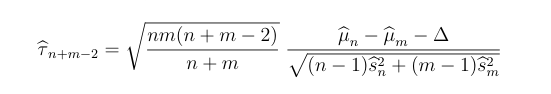

Проте в нашому випадку дисперсії ймовірно різні (проводити тест на рівність дисперсій я не буду)

Тут варто розглянути якісь асимптотично нормальні величини

У методичці Карташова є отака штука, але вона вимагає однакових розмірів вибірок  
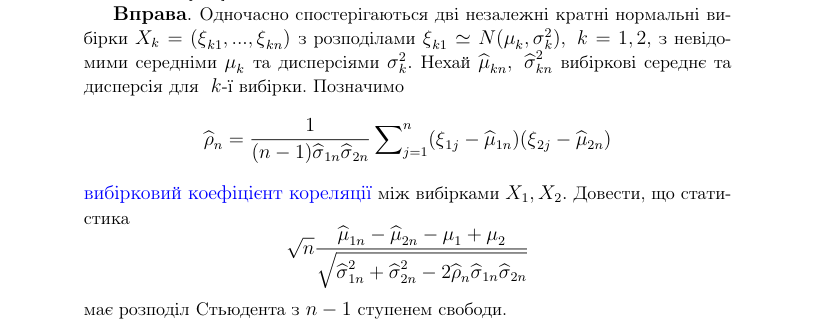

В результаті, поки що не знаю як робити цей пункт

**Продовження у пункті 13d**

### 13c

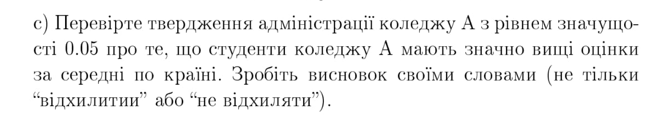

Спочатку визначимо, що таке "значно вищі". Середнє по країні - 79, середнє в коледжі А - 80. 

Сформулюємо це питання як статистичну гіпотезу.  
Нульова гіпотеза $H_0: EX = 79$  
Альтернативна гіпотеза $H_1: EX > 79$  
Рівень значущості 0.05

Використаю мою функцію `test_normal_t_greater` як раз для такого випадку: невідомі матсподівання та дисперсія і одностороння гіпотеза.
А також, обчислю довірчий інтервал для матсподівання із заданим рівнем впевненості

In [130]:
test_normal_t_greater(79, 400, 80, 5, 0.05)

Перевіряємо статистичну гіпотезу із рівнем значущості 0.05
  H0 : EX = 79  проти  H1 : EX > 79
  sample_n = 400; sample_mean = 80; sample_var = 5;
  t=8.93  >  t_crit=1.65
  Відхиляємо нульову гіпотезу, приймаючи альтернативну. 

  Результат ttest_1samp: 
  > t_sp= 8.93 
  > pvalue= 7.71e-18 
  > conf_interv= ConfidenceInterval(low=79.81544095771595, high=inf)
  Результат узгоджується із scipy 🥳


In [131]:
np.sqrt(5)

2.23606797749979

Дані узгоджуються з альтернативною гіпотезою про те, що студенти коледжу А отримують в середньому вищі оцінки.  
Наскільки вищі?  

Із ймовірністю 0.95 можна бути певним, що середня оцінка студентів коледжу А вища за 79.8

In [132]:
test_normal_t_greater(80, 400, 80, 5, 0.05)

Перевіряємо статистичну гіпотезу із рівнем значущості 0.05
  H0 : EX = 80  проти  H1 : EX > 80
  sample_n = 400; sample_mean = 80; sample_var = 5;
  t=0  <  t_crit=1.65
  Не можемо відхилити нульову гіпотезу із заданим рівнем значущості.

  Результат ttest_1samp: 
  > t_sp= 1.27e-13 
  > pvalue= 0.5 !!!
  > conf_interv= ConfidenceInterval(low=79.81544095771596, high=inf)
  Результат узгоджується із scipy 🥳


Як бачимо, дані не підтверджують гіпотезу, що середня оцінка коледжу А вища за 80.

Якщо вважати, що суттєва різниця це більше одного балу (наприклад, враховуючи округлення вниз), то я би робив висновок, що дані **не підтверджують** те, що студенти коледжу А отримують значно вищі оцінки

### 13d
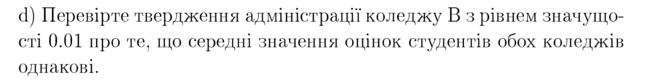

Та сама проблема що і у 13b, у нас явно різні дисперсії.

Спробую підійти інтуітивно. Можна зменшити вибірку А вполовину (наприклад, усереднивши попарно сусідні випадкові величини). Це призведе до нової вибірки із більшою дисперсією
$Z_k \sim \mathcal N(\mu_A, 2\sigma_A)$.

Спочатку спробуємо **модель 7**, двосторонню гіпотезу про рівність дисперсій  
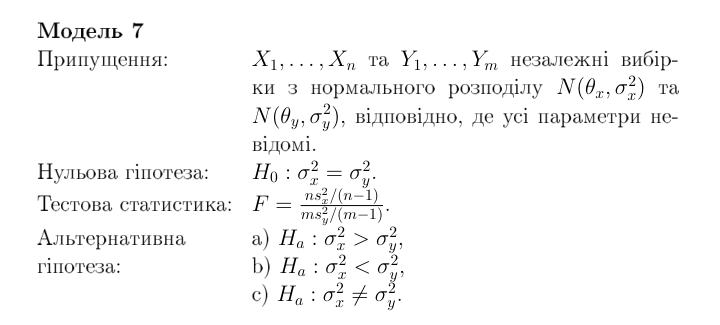  
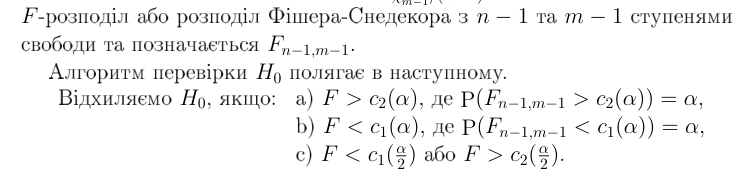

In [135]:
f = (n_a * var_a / (n_a -1)) / (n_b * var_b / (n_b - 1)) 
f_crit_left = sp.stats.f.ppf(0.01 / 2, n_a, n_b)
f_crit_right = sp.stats.f.ppf(1 - 0.01/2, n_a, n_b)

print(f"{f_crit_left=:.4g}  {f=:.4g}  {f_crit_right=:.4g}")

f_crit_left=0.734  f=0.4987  f_crit_right=1.382


f-статистика менша за ліву межу критичної області, вимушені відхилити гіпотезу про рівні дисперсії X та Y. 

Спробуємо повторити те саме для Z та Y. Зверну увагу, що $s^2_Z = 2s^2_A$, $n_Z = n_A/2$

In [136]:
n_z = n_a // 2
var_z = var_a * 2

f = (n_z * var_z / (n_z -1)) / (n_b * var_b / (n_b - 1)) 
f_crit_left = sp.stats.f.ppf(0.01 / 2, n_z, n_b)
f_crit_right = sp.stats.f.ppf(1 - 0.01/2, n_z, n_b)

print(f"{f_crit_left=:.4g}  {f=:.4g}  {f_crit_right=:.4g}")

f_crit_left=0.6937  f=1  f_crit_right=1.442


Бачимо, що з високою ймовірністю дисперсії Z та Y співпадатимуть.

Тепер можемо застосувати методи для розподілів із дисперсіями що співпадають. Наприклад, **модель 4**  
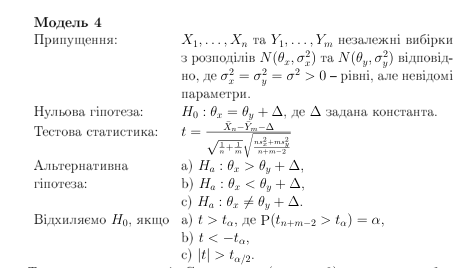

Нехай  
Нульова гіпотеза $H_0 : EZ = EY$  
Альтернативна гіпотеза (двостороння): $H_1 : EZ \ne EY$  
Де фактично $\Delta = 0$, а $EZ = EX$.

In [140]:
t = (mean_a - mean_b - 0) / (np.sqrt(1/n_z + 1/n_b) * np.sqrt((n_z*var_z + n_b*var_b) / (n_z + n_b - 2)))
t_crit_left = sp.stats.t.ppf(0.01/2, n_z+n_b-2)
t_crit_right = sp.stats.t.ppf(1-0.01/2, n_z+n_b-2)

print(f"{t_crit_left=:.4g}  {t=:.4g}  {t_crit_right=:.4g}")

t_crit_left=-2.588  t=15.77  t_crit_right=2.588


Статистика критерію більша за праве критичне значення, отже відхиляємо нульову гіпотезу про рівність матсподівань.


Дійсно, для $\Delta = 5$ матимемо інший результат:

In [141]:
t = (mean_a - mean_b - 5) / (np.sqrt(1/n_z + 1/n_b) * np.sqrt((n_z*var_z + n_b*var_b) / (n_z + n_b - 2)))
t_crit_left = sp.stats.t.ppf(0.01/2, n_z+n_b-2)
t_crit_right = sp.stats.t.ppf(1-0.01/2, n_z+n_b-2)

print(f"{t_crit_left=:.4g}  {t=:.4g}  {t_crit_right=:.4g}")

t_crit_left=-2.588  t=0  t_crit_right=2.588


Тобто з високою ймовірністю можемо припустити, що студенти коледжу А отримують в середньому на 5 балів вищі оцінки, ніж студенти коледжу Б

## Завдання 15

**TODO**

## Завдання 16

**TODO**